In [1]:
import pandas as pd
import numpy as np

from scipy.stats import beta
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

## Get Data

In [2]:
# df = pd.read_csv("emailResponse.csv")
# attempts = df.iloc[:,1:25].values
# success = df.iloc[:,25:49].values
# failure = attempts - success

In [3]:
#Generate Fake data
tmp = np.random.rand(10000,7)
true_rate = (tmp[:,:-2]*tmp[:,1:-1]*tmp[:,2:]
             *np.min(tmp,axis=1).reshape(-1,1)
             *np.array([0.1,0.2,0.5,0.2,0.1]).reshape(1,-1))

attempts = np.random.choice(10,true_rate.shape)
success = np.random.binomial(attempts,true_rate)
failure = attempts - success

In [52]:
df = pd.read_csv('~/Downloads/MultiArmBanditTestData.csv')
df.columns

Index(['DigitalMarketingID', 'Sent8am', 'Sent10am', 'Sent12pm', 'Sent2pm',
       'Sent4pm', 'Sent6pm', 'Sent8pm', 'Sent10pm', 'Ordered8am',
       'Ordered10am', 'Ordered12pm', 'Ordered2pm', 'Ordered4pm', 'Ordered6pm',
       'Ordered8pm', 'Orderd10pm', 'DOW', 'GroupNumber'],
      dtype='object')

In [69]:
success = df[['Ordered8am','Ordered10am', 'Ordered12pm', 'Ordered2pm', 'Ordered4pm', 'Ordered6pm','Ordered8pm', 'Orderd10pm']].values
failure = df[['Sent8am', 'Sent10am', 'Sent12pm', 'Sent2pm','Sent4pm', 'Sent6pm', 'Sent8pm', 'Sent10pm']].values

In [70]:
smoothing = 1e-9
success_rate = success/(success+failure+smoothing)
success_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Global Estimates

In [71]:
#a = success
#b = failure
#mean = a/(a+b)
#var = (1-mean)*(mean)/(a+b)

#(a+b) = N = (1-mean)*(mean)/var
# a = mean*(a+b) = mean*(N)
# b = (1-mean)*(a+b)= (1-mean)*(N)

def estimate_history(mean, var):
    N = (1-mean)*(mean)/var
    a = N*mean
    b = N*(1-mean)
    return a, b

In [72]:
estimate_history(0.1, 0.01)

(0.9, 8.1)

In [74]:
global_success = success.sum(axis=0)
# print(global_success)
global_failure = failure.sum(axis=0)
# print(global_failure)
global_mean, global_var = beta.stats(global_success,global_success + global_failure)
global_mean, global_var

(array([       nan, 0.00192394,        nan, 0.00134037, 0.0010584 ,
        0.00124301, 0.00113092, 0.00127008]),
 array([           nan, 1.82890094e-08,            nan, 5.45672958e-10,
        8.37098217e-11, 2.74338611e-10, 2.09087116e-09, 1.22980322e-08]))

In [75]:
success_rate.var(axis=0)

array([0.00000000e+00, 1.84250067e-06, 0.00000000e+00, 1.30635174e-04,
       1.17335266e-04, 9.60132918e-05, 2.91660369e-05, 4.11165771e-06])

In [76]:
s_est, f_est = estimate_history(global_mean, global_var + success_rate.var(axis=0))
s_est, f_est

(array([       nan, 1.98540175,        nan, 0.01373417, 0.00953705,
        0.01607226, 0.04379865, 0.39065837]),
 array([          nan, 1029.96155832,           nan,   10.2328477 ,
           9.00124783,   12.91403401,   38.68467443,  307.19465892]))

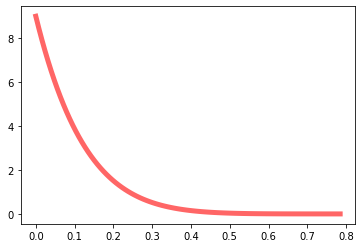

In [39]:
a, b = 1, 9
# mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

x = np.linspace(beta.ppf(1e-6, a, b),
              beta.ppf(1-1e-6, a, b), 100)
plt.plot(x, beta.pdf(x, a, b),
         'r-', lw=5, alpha=0.6, label='beta pdf')

In [77]:
success_adj = success + s_est.reshape(1,-1)
failure_adj = failure + f_est.reshape(1,-1)
success_rate_adj = success_adj/(success_adj+failure_adj)

In [93]:
# np.argmax(success_rate_adj[:,3])
success[753765,3],failure[753765,3],success_rate[753765,3],success_rate_adj[753765,3]

(4, 6, 0.39999999996, 0.19824255753879078)

## Bandit

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

array([[[0.00083584, 0.00161227, 0.00393316, 0.00100523, 0.00053159],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.00160689, 0.00285626, 0.00729802, 0.00433615, 0.00109899],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.00130575, 0.00337746, 0.00222408, 0.0031693 , 0.00191778],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.     